# Job Advertisement Analysis Pipeline
## Two-Stage Zone Classification and Skill Extraction

This notebook provides a complete end-to-end pipeline for analyzing job advertisements:
1. **Data Preprocessing**: Convert character-level annotations to token-level labels
2. **BERT Training**: Train zone classification model
3. **Model Evaluation**: Evaluate performance with metrics and visualizations
4. **Skill Extraction**: Extract skills using LLM (Gemini API)

**Author**: Carlos Leon  
**Course**: Advanced Generative AI, HSLU  
**Date**: December 14, 2025

**Note**: This notebook is designed to run in Google Colab. Ollama (local LLM) is not available in Colab.

## Google Colab Setup

If running in Google Colab, mount your Google Drive to access data files.

In [1]:
# Mount Google Drive (for Colab)
try:
    from google.colab import drive
    drive.mount('/content/drive')
    IN_COLAB = True
    print("Running in Google Colab")
except:
    IN_COLAB = False
    print("Running locally")

Running locally


## 1. Setup and Imports

Install required packages and import libraries.

In [2]:
# Install required packages
!pip install -q transformers seqeval scikit-learn google-generativeai python-dotenv matplotlib seaborn

import json
import os
import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizerFast, BertForTokenClassification, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import AdamW
from seqeval.metrics import classification_report, accuracy_score, f1_score
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import google.generativeai as genai
from getpass import getpass

print("All imports successful!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

c:\Users\carlo\OneDrive\Desktop\HSLU_Modules\SEM_5\Advanced Generative AI\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


All imports successful!
PyTorch version: 2.5.1+cu121
CUDA available: True
CUDA device: NVIDIA GeForce RTX 4070 Ti


## 2. Configuration

Set all configuration parameters for the pipeline.

In [3]:
# Set base directory
if IN_COLAB:
    # Adjust this path to where you uploaded your data in Google Drive
    BASE_DIR = '/content/drive/MyDrive/Advanced-GenAI'
else:
    BASE_DIR = '.'

# File paths
INPUT_FILE = os.path.join(BASE_DIR, 'data/annotated.json')
OUTPUT_DIR = os.path.join(BASE_DIR, 'data/processed')
MODEL_DIR = os.path.join(BASE_DIR, 'models/bert_zone_classifier')
EVAL_OUTPUT_DIR = os.path.join(BASE_DIR, 'outputs')
SKILLS_OUTPUT_FILE = os.path.join(BASE_DIR, 'outputs/skills.json')

# Model configuration
MODEL_NAME = 'bert-base-multilingual-cased'
MAX_LEN = 512
OVERLAP = 128
TEST_SIZE = 0.2
SEED = 42

# Training hyperparameters
BATCH_SIZE = 8
EPOCHS = 10
LEARNING_RATE = 2e-5
MAX_GRAD_NORM = 1.0
EARLY_STOPPING_PATIENCE = 3

# Set random seeds
torch.manual_seed(SEED)
np.random.seed(SEED)

# Create directories
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(EVAL_OUTPUT_DIR, exist_ok=True)

print("Configuration complete!")
print(f"Base directory: {BASE_DIR}")
print(f"Input file: {INPUT_FILE}")

Configuration complete!
Base directory: .
Input file: .\data/annotated.json


## 3. Data Preprocessing

Convert character-level annotations to token-level labels using BERT tokenization.

In [4]:
def load_data(file_path):
    """Load annotated job advertisement data from JSON file."""
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Input file not found at {file_path}")
    
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    return data

def parse_annotations(data):
    """Extract text content and label annotations from raw JSON data."""
    parsed_items = []
    items = data if isinstance(data, list) else [data]
    
    for item in items:
        text = item.get('content_clean') or item.get('data', {}).get('content_clean')
        if not text:
            continue
            
        annotations = item.get('annotations', [])
        labels = []
        
        if annotations:
            for annotation in annotations:
                result = annotation.get('result', [])
                for r in result:
                    value = r.get('value', {})
                    start = value.get('start')
                    end = value.get('end')
                    label_list = value.get('labels', [])
                    if start is not None and end is not None and label_list:
                        label = label_list[0]
                        labels.append({'start': start, 'end': end, 'label': label})
        
        parsed_items.append({'text': text, 'labels': labels})
    
    return parsed_items

def align_labels_with_tokens(tokenizer, text, labels, max_len=512, overlap=128):
    """Convert character-level annotations to token-level labels using sliding windows."""
    tokenized_inputs = tokenizer(
        text,
        return_offsets_mapping=True,
        add_special_tokens=False,
        truncation=False
    )
    
    input_ids = tokenized_inputs['input_ids']
    offsets = tokenized_inputs['offset_mapping']
    
    # Create character-level label array
    char_labels = ['O'] * len(text)
    for lbl in labels:
        start, end, label = lbl['start'], lbl['end'], lbl['label']
        for i in range(start, min(end, len(text))):
            if i == start:
                char_labels[i] = f'B-{label}'
            else:
                char_labels[i] = f'I-{label}'
    
    # Map to tokens
    token_labels = []
    for (start, end) in offsets:
        if start < len(char_labels):
            token_labels.append(char_labels[start])
        else:
            token_labels.append('O')
    
    # Sliding window
    input_ids_list = []
    attention_masks_list = []
    labels_list = []
    
    stride = max_len - overlap
    for i in range(0, len(input_ids), stride):
        # Get chunk (without special tokens yet)
        chunk_ids = input_ids[i:i+max_len]
        chunk_labels = token_labels[i:i+max_len]
        
        # Calculate how much padding we need
        # We want final length to be max_len (not max_len+2)
        # So we take max_len-2 tokens, add CLS and SEP, then pad to max_len
        chunk_ids = chunk_ids[:max_len-2]  # Leave room for CLS and SEP
        chunk_labels = chunk_labels[:max_len-2]
        
        # Add special tokens
        chunk_ids = [tokenizer.cls_token_id] + chunk_ids + [tokenizer.sep_token_id]
        chunk_labels = ['O'] + chunk_labels + ['O']
        
        # Pad to exactly max_len
        current_len = len(chunk_ids)
        padding_length = max_len - current_len
        
        chunk_ids += [tokenizer.pad_token_id] * padding_length
        chunk_labels += ['O'] * padding_length
        attention_mask = [1] * current_len + [0] * padding_length
        
        # Ensure exact length
        chunk_ids = chunk_ids[:max_len]
        chunk_labels = chunk_labels[:max_len]
        attention_mask = attention_mask[:max_len]
        
        input_ids_list.append(chunk_ids)
        attention_masks_list.append(attention_mask)
        labels_list.append(chunk_labels)
        
        if i + max_len >= len(input_ids):
            break
    
    return input_ids_list, attention_masks_list, labels_list

def create_label_map(all_labels_list):
    """Create bidirectional mappings between labels and integer IDs."""
    unique_labels = set()
    for labels in all_labels_list:
        for lbl in labels:
            unique_labels.add(lbl)
    
    unique_labels = sorted(list(unique_labels))
    label2id = {label: idx for idx, label in enumerate(unique_labels)}
    id2label = {idx: label for label, idx in label2id.items()}
    
    return label2id, id2label

print("Data preprocessing functions defined!")

Data preprocessing functions defined!


In [5]:
# Run preprocessing
print("Loading data...")
data = load_data(INPUT_FILE)
print(f"Loaded {len(data) if isinstance(data, list) else 1} documents")

print("\nParsing annotations...")
parsed_items = parse_annotations(data)
print(f"Parsed {len(parsed_items)} items")

print("\nInitializing tokenizer...")
tokenizer = BertTokenizerFast.from_pretrained(MODEL_NAME)

print("\nAligning labels with tokens...")
all_input_ids = []
all_attention_masks = []
all_labels = []

for item in tqdm(parsed_items, desc="Processing documents"):
    text = item['text']
    labels = item['labels']
    
    input_ids_list, attention_masks_list, labels_list = align_labels_with_tokens(
        tokenizer, text, labels, MAX_LEN, OVERLAP
    )
    
    all_input_ids.extend(input_ids_list)
    all_attention_masks.extend(attention_masks_list)
    all_labels.extend(labels_list)

print(f"\nGenerated {len(all_input_ids)} chunks from {len(parsed_items)} documents")

# Create label mappings
print("\nCreating label mappings...")
label2id, id2label = create_label_map(all_labels)
print(f"Found {len(label2id)} unique labels")

# Convert labels to IDs
all_label_ids = []
for labels in all_labels:
    label_ids = [label2id.get(lbl, label2id['O']) for lbl in labels]
    all_label_ids.append(label_ids)

# Train-test split
print("\nSplitting data...")
indices = list(range(len(all_input_ids)))
train_idx, test_idx = train_test_split(indices, test_size=TEST_SIZE, random_state=SEED)

# Create datasets
train_inputs = torch.tensor([all_input_ids[i] for i in train_idx], dtype=torch.long)
train_masks = torch.tensor([all_attention_masks[i] for i in train_idx], dtype=torch.long)
train_labels = torch.tensor([all_label_ids[i] for i in train_idx], dtype=torch.long)

test_inputs = torch.tensor([all_input_ids[i] for i in test_idx], dtype=torch.long)
test_masks = torch.tensor([all_attention_masks[i] for i in test_idx], dtype=torch.long)
test_labels = torch.tensor([all_label_ids[i] for i in test_idx], dtype=torch.long)

train_dataset = TensorDataset(train_inputs, train_masks, train_labels)
test_dataset = TensorDataset(test_inputs, test_masks, test_labels)

print(f"Train size: {len(train_dataset)}")
print(f"Test size: {len(test_dataset)}")

# Save processed data
print("\nSaving processed data...")
torch.save(train_dataset, os.path.join(OUTPUT_DIR, 'train_dataset.pt'))
torch.save(test_dataset, os.path.join(OUTPUT_DIR, 'test_dataset.pt'))

with open(os.path.join(OUTPUT_DIR, 'label2id.json'), 'w') as f:
    json.dump(label2id, f, indent=2)
with open(os.path.join(OUTPUT_DIR, 'id2label.json'), 'w') as f:
    json.dump(id2label, f, indent=2)

print("\nPreprocessing complete!")

Loading data...
Loaded 2699 documents

Parsing annotations...
Parsed 2699 items

Initializing tokenizer...

Aligning labels with tokens...


Processing documents: 100%|██████████| 2699/2699 [00:01<00:00, 1454.63it/s]



Generated 3706 chunks from 2699 documents

Creating label mappings...
Found 21 unique labels

Splitting data...
Train size: 2964
Test size: 742

Saving processed data...

Preprocessing complete!


## 4. BERT Model Training

Train the zone classification model with weighted loss and early stopping.

In [6]:
def calculate_class_weights(dataset, label2id):
    """Calculate class weights for weighted loss function."""
    all_labels = []
    for _, _, labels in dataset:
        all_labels.extend(labels.tolist())
    
    label_counts = {}
    for label_id in all_labels:
        if label_id != -100:
            label_counts[label_id] = label_counts.get(label_id, 0) + 1
    
    total = sum(label_counts.values())
    num_classes = len(label2id)
    
    weights = torch.ones(num_classes)
    for label_id, count in label_counts.items():
        weights[label_id] = total / (count * num_classes)
    
    return weights

print("Training utility functions defined!")

Training utility functions defined!


In [7]:
# Setup training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Calculate class weights
print("\nCalculating class weights...")
class_weights = calculate_class_weights(train_dataset, label2id)
class_weights = class_weights.to(device)
print(f"Class weights shape: {class_weights.shape}")

# Initialize model
print("\nInitializing model...")
model = BertForTokenClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id
)
model.to(device)
print(f"Model loaded with {len(label2id)} labels")

# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Setup optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
total_steps = len(train_dataloader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=total_steps
)

# Loss function
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights, ignore_index=-100)

print("\nTraining setup complete!")

Using device: cuda

Calculating class weights...
Class weights shape: torch.Size([21])

Initializing model...


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded with 21 labels

Training setup complete!


In [8]:
# Training loop
print("Starting training...\n")

best_val_loss = float('inf')
patience_counter = 0

for epoch in range(EPOCHS):
    print(f"{'='*60}")
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print(f"{'='*60}")
    
    # Training
    model.train()
    total_train_loss = 0
    
    for batch in tqdm(train_dataloader, desc="Training"):
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        
        model.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        
        # Reshape for loss calculation
        loss = loss_fn(logits.view(-1, len(label2id)), labels.view(-1))
        total_train_loss += loss.item()
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)
        optimizer.step()
        scheduler.step()
    
    avg_train_loss = total_train_loss / len(train_dataloader)
    print(f"Average train loss: {avg_train_loss:.4f}")
    
    # Validation
    model.eval()
    total_val_loss = 0
    total_val_accuracy = 0
    nb_eval_steps = 0
    
    with torch.no_grad():
        for batch in tqdm(val_dataloader, desc="Validation"):
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            
            loss = loss_fn(logits.view(-1, len(label2id)), labels.view(-1))
            total_val_loss += loss.item()
            
            # Calculate accuracy
            preds = torch.argmax(logits, dim=2)
            mask = (labels != -100)
            correct = ((preds == labels) & mask).sum().item()
            total = mask.sum().item()
            total_val_accuracy += correct / total if total > 0 else 0
            nb_eval_steps += 1
    
    avg_val_loss = total_val_loss / len(val_dataloader)
    avg_val_acc = total_val_accuracy / nb_eval_steps
    print(f"Validation loss: {avg_val_loss:.4f}")
    print(f"Validation Accuracy: {avg_val_acc:.4f}")
    
    # Early stopping and model saving
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        print("New best model! Saving...")
        model.save_pretrained(MODEL_DIR)
        torch.save(model.state_dict(), os.path.join(MODEL_DIR, 'best_model.pt'))
        print(f"Model saved to {MODEL_DIR}")
    else:
        patience_counter += 1
        print(f"Early stopping counter: {patience_counter}/{EARLY_STOPPING_PATIENCE}")
    
    if patience_counter >= EARLY_STOPPING_PATIENCE:
        print(f"\nEarly stopping triggered after {epoch + 1} epochs")
        break

print("\n" + "="*60)
print("Training complete!")
print(f"Best model saved to: {MODEL_DIR}")
print("="*60)

Starting training...

Epoch 1/10


Training: 100%|██████████| 371/371 [01:08<00:00,  5.38it/s]


Average train loss: 1.3987


Validation: 100%|██████████| 93/93 [00:04<00:00, 20.78it/s]


Validation loss: 0.8735
Validation Accuracy: 0.8342
New best model! Saving...
Model saved to .\models/bert_zone_classifier
Epoch 2/10


Training: 100%|██████████| 371/371 [01:08<00:00,  5.41it/s]


Average train loss: 0.7244


Validation: 100%|██████████| 93/93 [00:04<00:00, 20.79it/s]


Validation loss: 0.8073
Validation Accuracy: 0.8508
New best model! Saving...
Model saved to .\models/bert_zone_classifier
Epoch 3/10


Training: 100%|██████████| 371/371 [01:08<00:00,  5.38it/s]


Average train loss: 0.5164


Validation: 100%|██████████| 93/93 [00:04<00:00, 20.41it/s]


Validation loss: 0.7463
Validation Accuracy: 0.8634
New best model! Saving...
Model saved to .\models/bert_zone_classifier
Epoch 4/10


Training: 100%|██████████| 371/371 [01:08<00:00,  5.38it/s]


Average train loss: 0.4010


Validation: 100%|██████████| 93/93 [00:04<00:00, 20.40it/s]


Validation loss: 0.8541
Validation Accuracy: 0.8782
Early stopping counter: 1/3
Epoch 5/10


Training: 100%|██████████| 371/371 [01:08<00:00,  5.39it/s]


Average train loss: 0.3075


Validation: 100%|██████████| 93/93 [00:04<00:00, 20.43it/s]


Validation loss: 0.8958
Validation Accuracy: 0.8830
Early stopping counter: 2/3
Epoch 6/10


Training: 100%|██████████| 371/371 [01:08<00:00,  5.38it/s]


Average train loss: 0.2415


Validation: 100%|██████████| 93/93 [00:04<00:00, 20.39it/s]

Validation loss: 0.9528
Validation Accuracy: 0.8903
Early stopping counter: 3/3

Early stopping triggered after 6 epochs

Training complete!
Best model saved to: .\models/bert_zone_classifier


## 5. Model Evaluation

Evaluate the trained model and generate metrics and visualizations.

In [9]:
# Load best model for evaluation
print("Loading best model for evaluation...")
model = BertForTokenClassification.from_pretrained(MODEL_DIR)
model.to(device)
model.eval()

# Prepare for evaluation
test_dataloader = DataLoader(test_dataset, batch_size=16)

true_labels_all = []
pred_labels_all = []

print("\nRunning inference on test set...")
with torch.no_grad():
    for batch in tqdm(test_dataloader, desc="Evaluating"):
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=2)
        
        # Convert to labels
        for i in range(len(labels)):
            true_seq = []
            pred_seq = []
            for j in range(len(labels[i])):
                if labels[i][j] != -100:
                    true_label = id2label[labels[i][j].item()]
                    pred_label = id2label[preds[i][j].item()]
                    
                    # Remove special tokens
                    if true_label not in ['[CLS]', '[SEP]', '[PAD]']:
                        true_seq.append(true_label)
                        pred_seq.append(pred_label)
            
            if true_seq:
                true_labels_all.append(true_seq)
                pred_labels_all.append(pred_seq)

print(f"\nProcessed {len(true_labels_all)} sequences")

Loading best model for evaluation...

Running inference on test set...


Evaluating: 100%|██████████| 47/47 [00:32<00:00,  1.46it/s]


Processed 742 sequences


In [10]:
# Calculate metrics
print("Calculating metrics...")

# seqeval metrics
report = classification_report(true_labels_all, pred_labels_all, output_dict=True)
accuracy = accuracy_score(true_labels_all, pred_labels_all)
f1 = f1_score(true_labels_all, pred_labels_all)

print(f"\nAccuracy: {accuracy:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"\nPer-label metrics:")
for label, metrics in report.items():
    if isinstance(metrics, dict):
        print(f"{label:30s} - P: {metrics['precision']:.3f}, R: {metrics['recall']:.3f}, F1: {metrics['f1-score']:.3f}")

# Save report
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return super(NumpyEncoder, self).default(obj)

report_data = {
    'classification_report': report,
    'accuracy': accuracy,
    'f1_score': f1
}

with open(os.path.join(EVAL_OUTPUT_DIR, 'evaluation_report.json'), 'w') as f:
    json.dump(report_data, f, indent=2, cls=NumpyEncoder)

print(f"\nEvaluation report saved to {EVAL_OUTPUT_DIR}/evaluation_report.json")

Calculating metrics...

Accuracy: 0.8634
F1-score: 0.0970

Per-label metrics:
Abschlüsse                     - P: 0.141, R: 0.385, F1: 0.206
Anstellung                     - P: 0.058, R: 0.233, F1: 0.093
Arbeitsumfeld                  - P: 0.003, R: 0.083, F1: 0.005
Benefits                       - P: 0.066, R: 0.366, F1: 0.112
Bewerbungsprozess              - P: 0.033, R: 0.174, F1: 0.056
Challenges                     - P: 0.037, R: 0.400, F1: 0.067
Erfahrung                      - P: 0.172, R: 0.484, F1: 0.254
Firmenbeschreibung             - P: 0.014, R: 0.093, F1: 0.025
Firmenkundenbeschreibung       - P: 0.104, R: 0.456, F1: 0.169
Fähigkeiten und Inhalte        - P: 0.041, R: 0.149, F1: 0.064
micro avg                      - P: 0.060, R: 0.255, F1: 0.097
macro avg                      - P: 0.067, R: 0.282, F1: 0.105
weighted avg                   - P: 0.070, R: 0.255, F1: 0.108

Evaluation report saved to .\outputs/evaluation_report.json


Generating confusion matrix...


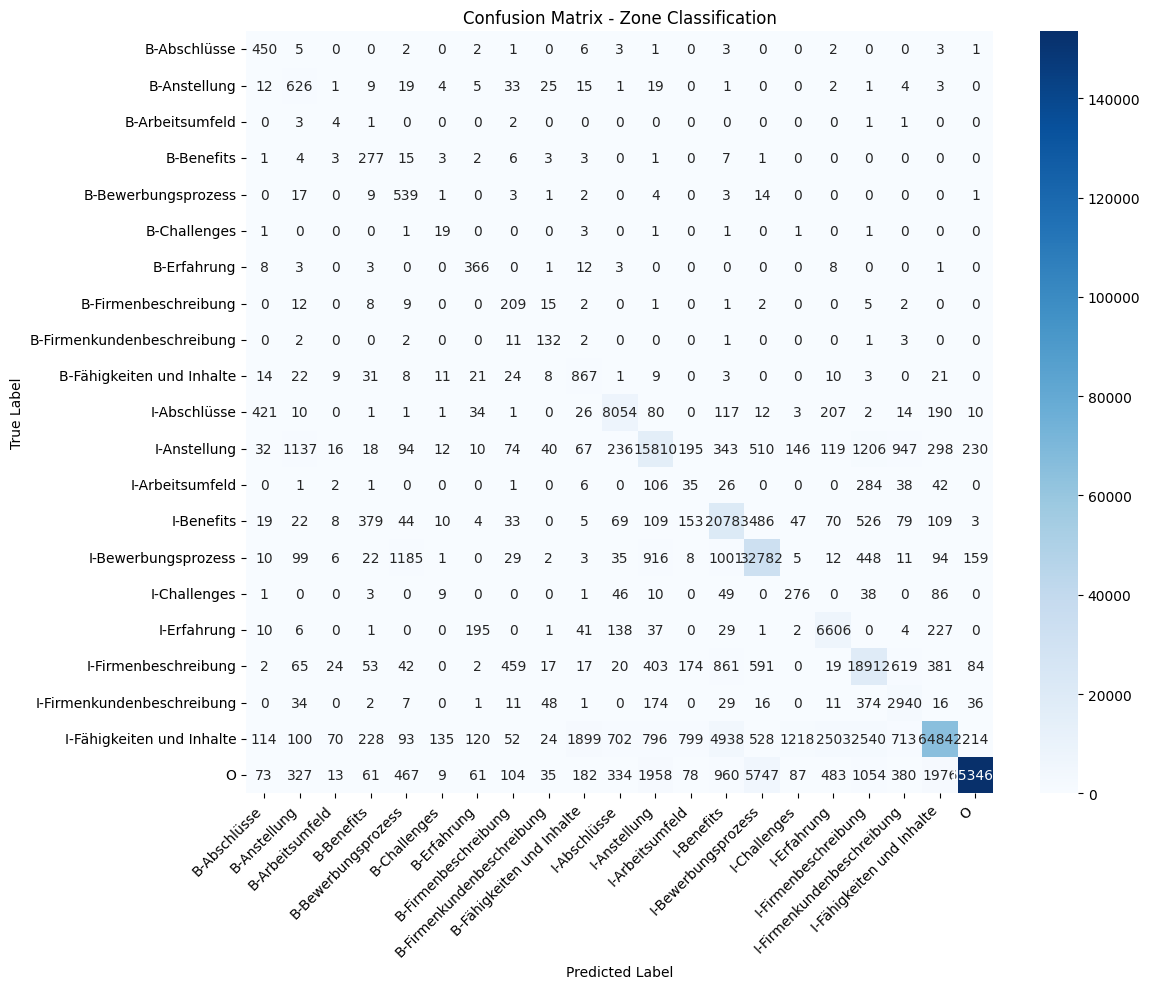

Confusion matrix saved to .\outputs/confusion_matrix.png


In [11]:
# Generate confusion matrix
print("Generating confusion matrix...")

# Flatten labels
true_flat = [label for seq in true_labels_all for label in seq]
pred_flat = [label for seq in pred_labels_all for label in seq]

# Get unique labels
unique_labels = sorted(list(set(true_flat + pred_flat)))

# Create confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true_flat, pred_flat, labels=unique_labels)

# Plot
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=unique_labels, yticklabels=unique_labels)
plt.title('Confusion Matrix - Zone Classification')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(EVAL_OUTPUT_DIR, 'confusion_matrix.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"Confusion matrix saved to {EVAL_OUTPUT_DIR}/confusion_matrix.png")

## 6. Skill Extraction

Extract skills from job advertisements using the trained BERT model and Gemini API.

In [ ]:
# Setup Gemini API
print("Setting up Gemini API...")
print("Please enter your Gemini API key:")
api_key = getpass("API Key: ")

try:
    genai.configure(api_key=api_key)
    llm = genai.GenerativeModel('gemini-1.5-pro')
    print("Gemini API configured successfully")
except Exception as e:
    print(f"Failed to setup Gemini: {e}")
    llm = None

Setting up Gemini API...
Please enter your Gemini API key:


In [ ]:
def extract_skills_with_gemini(llm, text_segment):
    """Extract skills using Gemini API."""
    if not llm:
        return []
    
    prompt = f"""You are an expert HR analyst. Extract specific skills from this job advertisement text.

Input Text: "{text_segment}"

Task: Extract a list of technical and soft skills mentioned in the text.
Constraints:
1. Each skill must be a phrase of 2 to 5 words.
2. Output ONLY a valid Python list of strings, nothing else.
3. Do not include generic phrases.
4. If no skills are found, return an empty list [].

Output Format: ["skill one", "skill two", ...]"""
    
    try:
        response = llm.generate_content(prompt)
        text = response.text.strip()
        
        # Parse response
        if '```' in text:
            text = text.split('```')[1] if len(text.split('```')) > 1 else text
            text = text.replace('python', '').replace('json', '').strip()
        
        start_idx = text.find('[')
        end_idx = text.rfind(']')
        
        if start_idx != -1 and end_idx != -1:
            list_str = text[start_idx:end_idx+1]
            skills = eval(list_str)
            
            filtered = [s for s in skills if 2 <= len(s.split()) <= 5]
            return filtered
    except Exception as e:
        print(f"Gemini error: {str(e)[:50]}...")
        return []
    
    return []

def get_zones(model, tokenizer, text, id2label, target_label='Fähigkeiten und Inhalte'):
    """Identify skill zones using BERT model."""
    # Tokenize
    encoding = tokenizer(
        text,
        return_tensors='pt',
        return_offsets_mapping=True,
        max_length=MAX_LEN,
        truncation=True,
        padding='max_length'
    )
    
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    offsets = encoding['offset_mapping'][0]
    
    # Predict
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=2)[0]
    
    # Extract zones
    segments = []
    current_start = None
    current_end = None
    
    for idx, (pred, (start, end)) in enumerate(zip(preds, offsets)):
        if start == 0 and end == 0:
            continue
        
        label_id = pred.item()
        label = id2label.get(label_id, id2label.get(str(label_id), 'O'))
        
        if target_label in label:
            if current_start is None:
                current_start = start.item()
            current_end = end.item()
        else:
            if current_start is not None:
                segment_text = text[current_start:current_end]
                segments.append(segment_text)
                current_start = None
                current_end = None
    
    if current_start is not None:
        segment_text = text[current_start:current_end]
        segments.append(segment_text)
    
    return segments

print("Skill extraction functions defined!")

In [ ]:
# Run skill extraction
print("Loading data...")
with open(INPUT_FILE, 'r', encoding='utf-8') as f:
    data = json.load(f)

items = data if isinstance(data, list) else [data]
items = items[:5]  # Process first 5 for demonstration

print(f"Processing {len(items)} documents...\n")

results = []

for item in tqdm(items, desc="Extracting skills"):
    text = item.get('content_clean') or item.get('data', {}).get('content_clean')
    if not text:
        continue
    
    # Get skill zones
    segments = get_zones(model, tokenizer, text, id2label)
    
    # Extract skills from each segment
    doc_skills = []
    for seg in segments:
        if len(seg) < 20:
            continue
        
        skills = extract_skills_with_gemini(llm, seg)
        doc_skills.extend(skills)
    
    results.append({
        'text_snippet': text[:100],
        'extracted_skills': list(set(doc_skills))
    })

# Save results
with open(SKILLS_OUTPUT_FILE, 'w', encoding='utf-8') as f:
    json.dump(results, f, indent=2, ensure_ascii=False)

print(f"\nSkills extracted to {SKILLS_OUTPUT_FILE}")

# Display results
print("\n" + "="*60)
print("EXTRACTED SKILLS SAMPLE")
print("="*60)
for i, result in enumerate(results[:3], 1):
    print(f"\nDocument {i}:")
    print(f"Text: {result['text_snippet']}...")
    print(f"Skills ({len(result['extracted_skills'])}):")
    for skill in result['extracted_skills'][:10]:
        print(f"  - {skill}")

## 7. Pipeline Summary

The complete pipeline has been executed:

1. Data Preprocessing: Converted character-level annotations to token-level labels
2. BERT Training: Trained zone classification model with weighted loss
3. Model Evaluation: Generated metrics and confusion matrix
4. Skill Extraction: Extracted skills using BERT + Gemini API

### Output Files

- `data/processed/train_dataset.pt` - Training data
- `data/processed/test_dataset.pt` - Test data
- `data/processed/label2id.json` - Label mappings
- `models/bert_zone_classifier/` - Trained model
- `outputs/evaluation_report.json` - Evaluation metrics
- `outputs/confusion_matrix.png` - Confusion matrix visualization
- `outputs/skills.json` - Extracted skills

### Next Steps

- Review evaluation metrics to understand model performance
- Analyze extracted skills for quality
- Consider improvements suggested in the project report